**Загрузка библиотек:**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

## Исследовательский анализ данных

### Загрузка данных:

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels.sort_values(by='file_name'))
labels.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Загружаем датасет через flow_from_dataframe:

In [4]:
datagen = ImageDataGenerator(
    rescale=1/255
)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels, 
    directory='/datasets/faces/final_files/', 
    x_col='file_name', 
    y_col='real_age',
    class_mode='raw', 
    target_size=(150, 150), 
    batch_size=32,
    seed=12346
)

Found 7591 validated image filenames.


In [5]:
features, target = next(datagen_flow)

Что имеем:
- 7591 фотографий

Labels:
- 7591 строка, 2 столбца (с названием файла и возрастом)
- типы ожидаемые: object, int
- пропусков нет, все фотографии размечены



### Дубликаты

Убедимся, что данные уникальны и не повторяются:

In [6]:
print ('Длина датасета: ', len(labels))
print ('\nУникальные значения в столбцах:\n', labels.nunique())

Длина датасета:  7591

Уникальные значения в столбцах:
 file_name    7591
real_age       97
dtype: int64


- Количество уникальных значений `file_name`соответствует длине датасета. Значит, информация о возрасте предоставлена единожды для каждой фотографии.

- Уникальных значений возраста - 97

### Распределение возраста в выборке

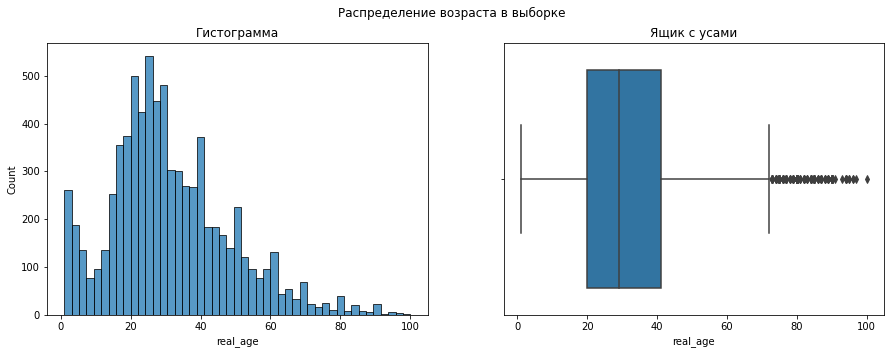

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Количество возрастов:  97


In [7]:
plt.figure(figsize=[15, 5])
plt.suptitle('Распределение возраста в выборке')

plt.subplot(1, 2, 1)
sns.histplot(data=labels, x='real_age')
plt.title('Гистограмма')

plt.subplot(1, 2, 2)
sns.boxplot(data=labels, x='real_age')
plt.title('Ящик с усами')
plt.show()

display(pd.DataFrame(labels['real_age'].describe()).T)
print ('Количество возрастов: ', labels['real_age'].nunique())

Вывод по графикам:

- Распределение близко к нормальному со смещением влево.


- Возраст от 1 до 100 лет. 
- Всего есть 97 значений возраста - на ящике с усами в районе выбросов видны пропуски после 90 лет. Вероятно, отсутствующие значения возраста - в этой области.
- Люди младше 41 года составляют 75% датасета


- Средний возраст - 31 год.  
- Медиана - 29 лет.  
- Стандартное отклонение - 17.


- Межквартильный размах от 20 до 41 года.  
- Статистически нормальными могут считаться значения от 1 до примерно 73 лет.


Количество фотографий снижается с увеличением возраста после 30 лет.

Есть резкое увеличение в районе 40, 50, 60, 70, 80 лет. Возможно, данные были проставлены вручную "на глаз" либо округлены для некоторых случаев.

### Фотографии

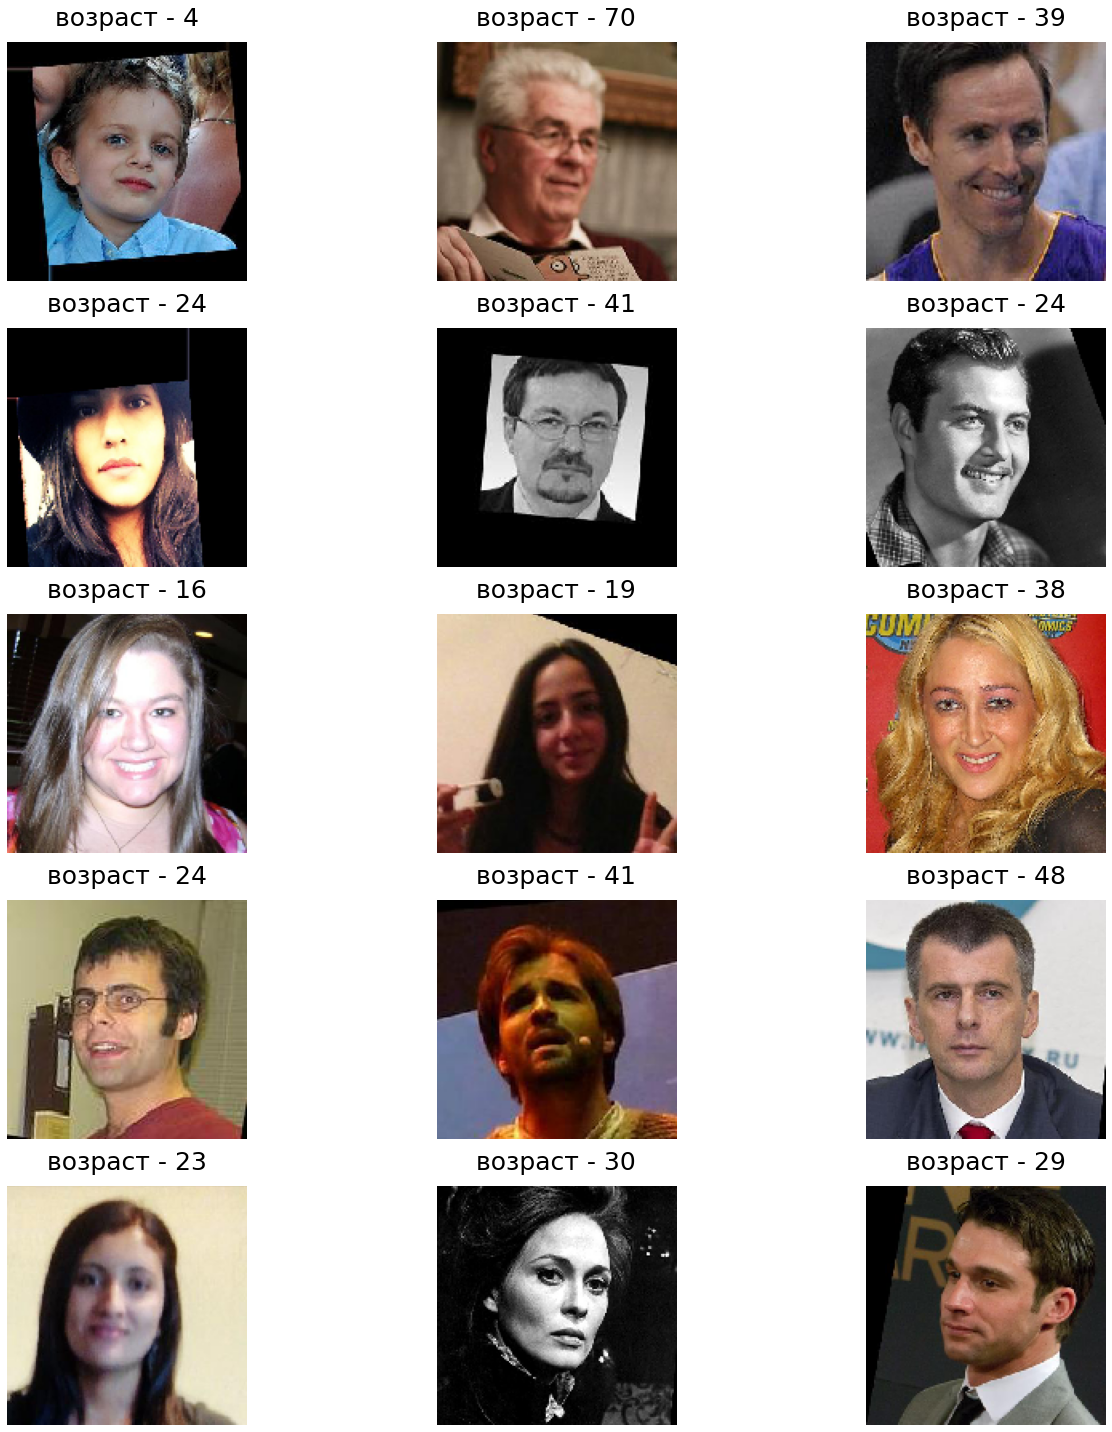

In [7]:
plt.figure(figsize=[20, 20])
for i in range (15):
    plt.subplot(5, 3, i+1)
    plt.imshow(features[i])
    plt.axis('off')
    plt.title(f'возраст - {target[i]}', fontsize=25, pad=17)
plt.tight_layout()
plt.show()

Некоторые фотографии "съехали" относительно своих рамок. Вероятно, в процессе обработки это было сделано намеренно, чтобы черты лица распологались в центре кадра, ровно по вертикали и горизонтали.

По большей части лицо полностью входит в кадр, повернуто перпендикулярно камере.

Есть как цветные, так и черно-белые фото.

### Вывод

Датасет состоит из 7591 размеченных фотографий.

Имеем данные от 1 до 100 лет. Есть возраста на промежутке 90-100 лет, не представленные в датасете.  
В 75% случаев возраст не превышает 41 год. Межквартильный размах - от 20 до 41 года.

- Средний возраст - 31 год. Медиана - 29 лет.

Есть цветные и чб фотографии, в основном лица распологаются по центру кадра, повернуты перпендикулярно горизонтальной оси.

**К обучению модели:**

Учитывая, что камеры в магазине будут зафиксированы и расположены примерно ровно относительно горизонта, каждый входящий посетитель будет примерно одинаково ориентирован относительно кадра, соответственно, используем следующие способы аугментации:

- horizontal_flip,  
- width_shift_range, height_shift_range (при передвижении в разный момент времени посетители будут находиться в разных точках кадра)

Следующие способы аугментации использовать не будем:

- Vertical_flip: в нашем случае будет бесполезен и даже вреден: поскольку все фотографии целенаправленно выровнены, приведены к правильному расположению по вертикали (низ-низ верх-верх), добавление перевернутых фотографий лишь запутает модель. Если нет задачи обучить нейронную сеть определять возраст при любой ориентации - не стоит делать аугментацию по вертикали.  
- Добавлять аугментацию по rotation_range также не стоит.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

____

Описание функций:

- Выборку разобьем на тренировочную и валидационную в соотношении 75 к 25.
- Применим следующие методы аугментации: horizontal_flip=True, width_shift_range=0.3, height_shift_range=0.3, zoom_range=0.1
   - (*поворот по горизонтали, смещение по ширине и высоте относительно центра в диапазоне от -30% до +30%, увеличение или уменьшение кадра в рамках имеющейся размерности на -10% - +10%*)
- Обучаем сеть на основе предобученной ResNet50, с использованием уже имеющихся весов. 
- Последний слой состоит из 1 нейрона, т.к. решается задача классификации
- Функция активации - 'relu'
- Оптимизатор (метод градиентного спуска) - Adam с learning rate=0.00001
- Функция ошибки: loss='mean_squared_error'
- Метрика: 'mae'
___
**Код обучения модели:**

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255, 
        horizontal_flip=True,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.1
    )
    
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'), 
        directory=path+'/final_files/', 
        x_col='file_name', 
        y_col='real_age',
        class_mode='raw', 
        target_size=(150, 150), 
        batch_size=32,
        subset='training',
        seed=12346
    )
    
    return train_datagen_flow
    
def load_test(path):
    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255
    )
    
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'), 
        directory=path+'/final_files/', 
        x_col='file_name', 
        y_col='real_age',
        class_mode='raw', 
        target_size=(150, 150), 
        batch_size=32,
        subset='validation',
        seed=12346
    )
    
    return test_datagen_flow
    
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.00001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model 


```

**Результат:**

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/20
2025-02-01 00:26:39.021705: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-02-01 00:26:39.480866: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 83s - loss: 980.8910 - mae: 26.7398 - val_loss: 1033.2375 - val_mae: 27.4757
Epoch 2/20
178/178 - 73s - loss: 337.8876 - mae: 14.4816 - val_loss: 992.1459 - val_mae: 26.7598
Epoch 3/20
178/178 - 80s - loss: 172.8969 - mae: 9.8773 - val_loss: 1043.2517 - val_mae: 27.7236
Epoch 4/20
178/178 - 78s - loss: 126.7558 - mae: 8.5190 - val_loss: 241.1700 - val_mae: 11.2967
Epoch 5/20
178/178 - 77s - loss: 107.0534 - mae: 7.8999 - val_loss: 117.7246 - val_mae: 8.1167
Epoch 6/20
178/178 - 77s - loss: 94.2052 - mae: 7.4426 - val_loss: 101.1097 - val_mae: 7.5112
Epoch 7/20
178/178 - 77s - loss: 88.9095 - mae: 7.1724 - val_loss: 93.0589 - val_mae: 7.3505
Epoch 8/20
178/178 - 77s - loss: 84.4365 - mae: 7.0265 - val_loss: 94.4707 - val_mae: 7.5076
Epoch 9/20
178/178 - 77s - loss: 76.0481 - mae: 6.7439 - val_loss: 96.4888 - val_mae: 7.5908
Epoch 10/20
178/178 - 77s - loss: 71.7864 - mae: 6.5123 - val_loss: 91.6389 - val_mae: 7.2514
Epoch 11/20
178/178 - 77s - loss: 66.2071 - mae: 6.3112 - val_loss: 92.5421 - val_mae: 7.2528
Epoch 12/20
178/178 - 76s - loss: 63.6846 - mae: 6.1574 - val_loss: 89.9409 - val_mae: 7.1975
Epoch 13/20
178/178 - 78s - loss: 61.9480 - mae: 6.0903 - val_loss: 90.3770 - val_mae: 7.1387
Epoch 14/20
178/178 - 77s - loss: 58.0718 - mae: 5.8886 - val_loss: 92.5203 - val_mae: 7.2537
Epoch 15/20
178/178 - 78s - loss: 55.3543 - mae: 5.7259 - val_loss: 91.5245 - val_mae: 7.1558
Epoch 16/20
178/178 - 74s - loss: 54.0986 - mae: 5.6807 - val_loss: 90.7312 - val_mae: 7.1625
Epoch 17/20
178/178 - 72s - loss: 49.3146 - mae: 5.4528 - val_loss: 88.9168 - val_mae: 7.0674
Epoch 18/20
178/178 - 72s - loss: 48.9702 - mae: 5.4073 - val_loss: 90.2776 - val_mae: 7.1439
Epoch 19/20
178/178 - 72s - loss: 46.6570 - mae: 5.2895 - val_loss: 88.5423 - val_mae: 7.0069
Epoch 20/20
178/178 - 72s - loss: 45.5155 - mae: 5.2329 - val_loss: 87.9533 - val_mae: 7.0411
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 87.9533 - mae: 7.0411

```

___

**Итог:**
- Значение метрики MAE=7.0411. Цель достигнута.

## Анализ обученной модели

Модель успешно обучена, метрика - ниже максимального порогого значения.
- MAE=7.04

Качество модели:
- Достигнуто значение MAE ниже 8.
- Подобрано хорошее значение learning_rate: метрика MAE валидационной выборки уменьшается равномерно, с уменьшением на каждой эпохе без скачков.
- Видно, что на каждой эпохе функция потерь уменьшается на валидационной выборке вместе с тренировочной. Нет проблемы переобучения.
- Возможно, при увеличении размера батчей и количества эпох, можно достигнуть лучшего результата.

Скорость обучения:
- Каждая эпоха заняла порядка 70-80 секунд. Все обучение заняло около 20-30 минут. Довольно неплохой результат. 
- Хоть нашей метрикой была MAE, в качество функции потерь использовали MSE - это помогло сделать обучение нейронной сети быстрее.

Обучение сети на основе предобученной ResNet50, с использованием уже имеющихся весов, позволило сэкономить время на обучение модели и достичь довольно высокого качества.

**Выводы для бизнеса:**

Результат метрики MAE=7.04 означает, что в среднем предсказания возраста моделью отличаются от реальных возрастов примерно на 7 лет.

Одно из применений модели: предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.   
- Если возрастные группы разбиты на 10-15 лет (вероятно, даже больше), то эта ошибка (в 7 лет) не критична.

Вторая задача: контролировать добросовестность кассиров при продаже алкоголя.  
- В данном случае не можем гарантировать, что модель поможет качественно решить задачу. Здесь имеет место высокая чувствительность к погрешности предсказания модели. 
- С учетом достигнутой средней ошибки в 7 лет, можем сказать, что для возрастов 11-25 лет высока вероятность ошибки в оценке того, ниже или выше 18 лет реальный возраст клиента.
- При предсказанном возрасте посетителя выше 26 лет или ниже 11 с большей уверенностью можно оценивать, является ли постетель совершеннолетним или нет.

## Общий вывод

Построена и обучена модель, определяющая возраст человека по фотографии.

Модель:
- Сеть на основе предобученной ResNet50
- Оптимизатор (метод градиентного спуска) - Adam с learning rate=0.00001
- Функция ошибки: loss='mean_squared_error'
- Метрика: 'mae'
- Функция активации - 'relu'
- Аугментации: horizontal_flip=True, width_shift_range=0.3, height_shift_range=0.3, zoom_range=0.1
- Батчи: 16, Эпох: 20

Результат:
- MAE = 7.0411

__________



Исследовательский анализ данных:
- Датасет состоит из 7591 размеченных фотографий.
- Имеем данные от 1 до 100 лет. Есть возраста на промежутке 90-100 лет, не представленные в датасете.  В 75% случаев возраст не превышает 41 год. Межквартильный размах - от 20 до 41 года.
- Средний возраст - 31 год. Медиана - 29 лет.
- Цветные и чб фотографии, в основном лица распологаются по центру кадра, повернуты перпендикулярно горизонтальной оси.

